In [1]:
import os
import random

import imageio
import jax.numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys; sys.path.append("..")
from sampling.distributions import Normal
from sampling.envelopes import naive_envelope, piecewise_linear_envelope
from sampling.linear_samplers import (TriangleSampler, create_segment_sampler,
                                      piecewise_linear_sampler)

plt.style.use("seaborn-v0_8-darkgrid")

In [2]:
plots_path = "../plots"

In [3]:
def visualize_sampler(sampler, num_samples=100_000, num_bins=100, fname=None):
    # Generating points for the line plot of f
    x_range = np.linspace(*sampler.domain, 500)
    y_values = [sampler.f(x) for x in x_range]

    # Generating samples
    samples = [sampler.draw() for _ in range(num_samples)]

    # Creating subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plotting the piecewise linear function
    axs[0].plot(x_range, y_values, label="f(x)")
    axs[0].set_title("Function")
    axs[0].set_ylim(0, max(y_values))
    axs[0].legend()

    # Plotting the histogram of samples
    axs[1].hist(
        samples, bins=num_bins, density=True, alpha=0.7, label="Sampled Distribution"
    )
    axs[1].set_title("Histogram of Samples")
    axs[1].legend()

    plt.tight_layout()
    plt.show()
    if fname:
        fig.savefig(f"{plots_path}/{fname}")

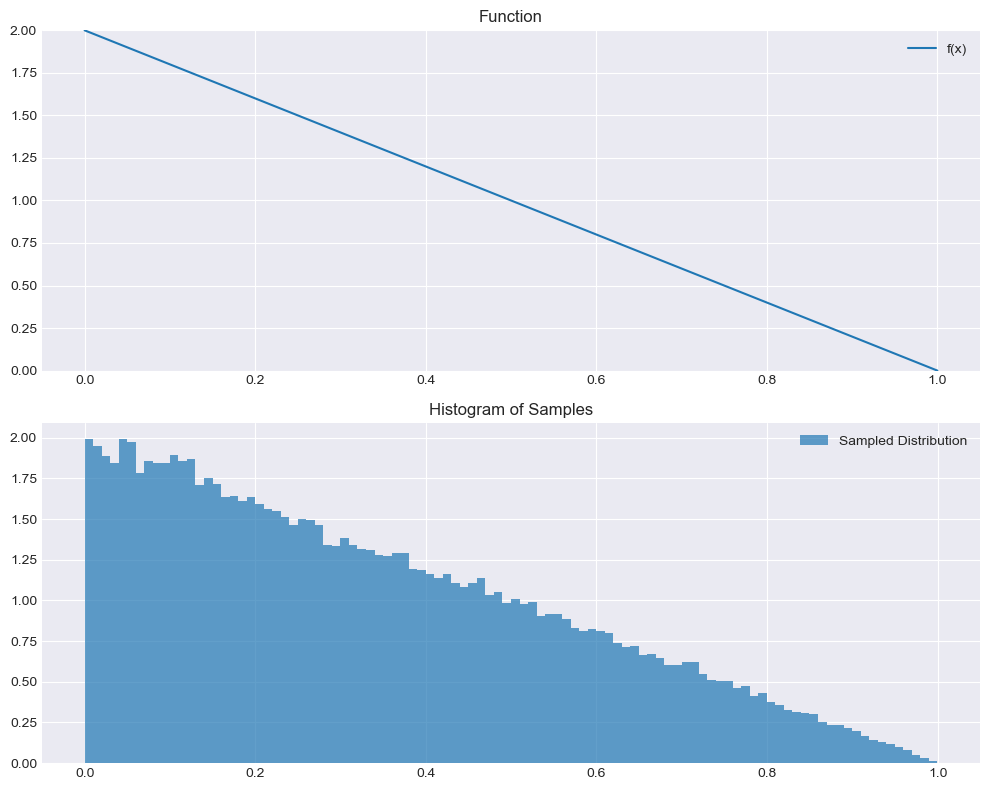

In [4]:
sampler = TriangleSampler(0, 2, 1, 0)
visualize_sampler(sampler, fname="triangle.png")

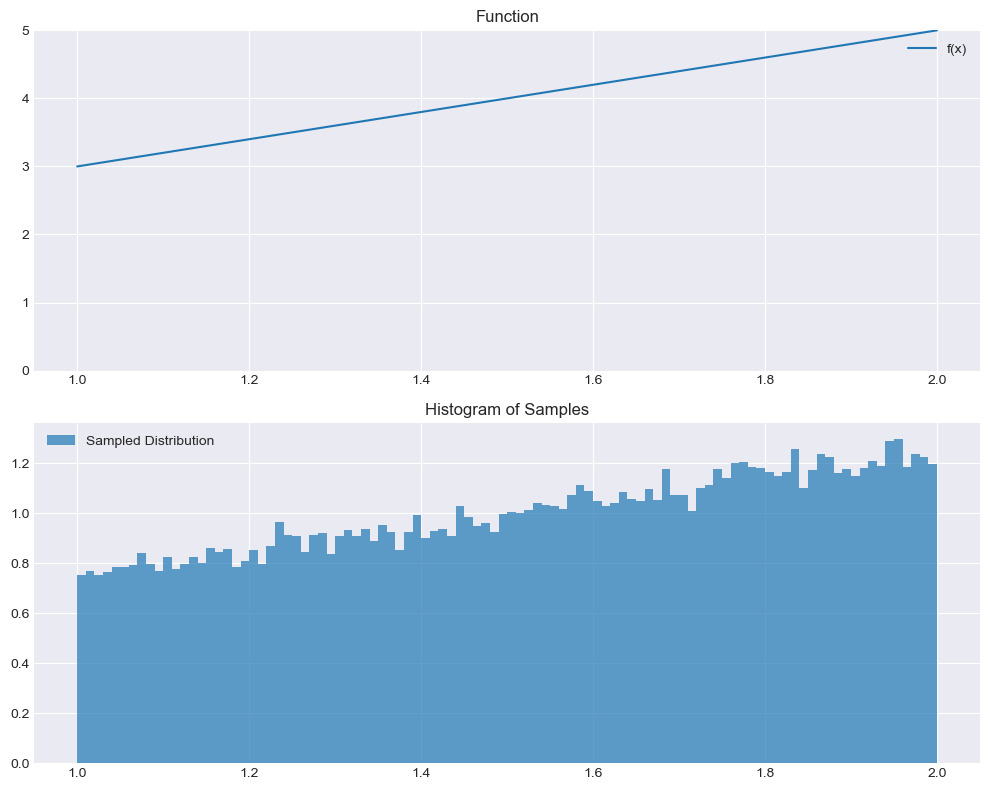

In [5]:
sampler = create_segment_sampler((1, 3), (2, 5))
visualize_sampler(sampler, fname="trapezium.png")

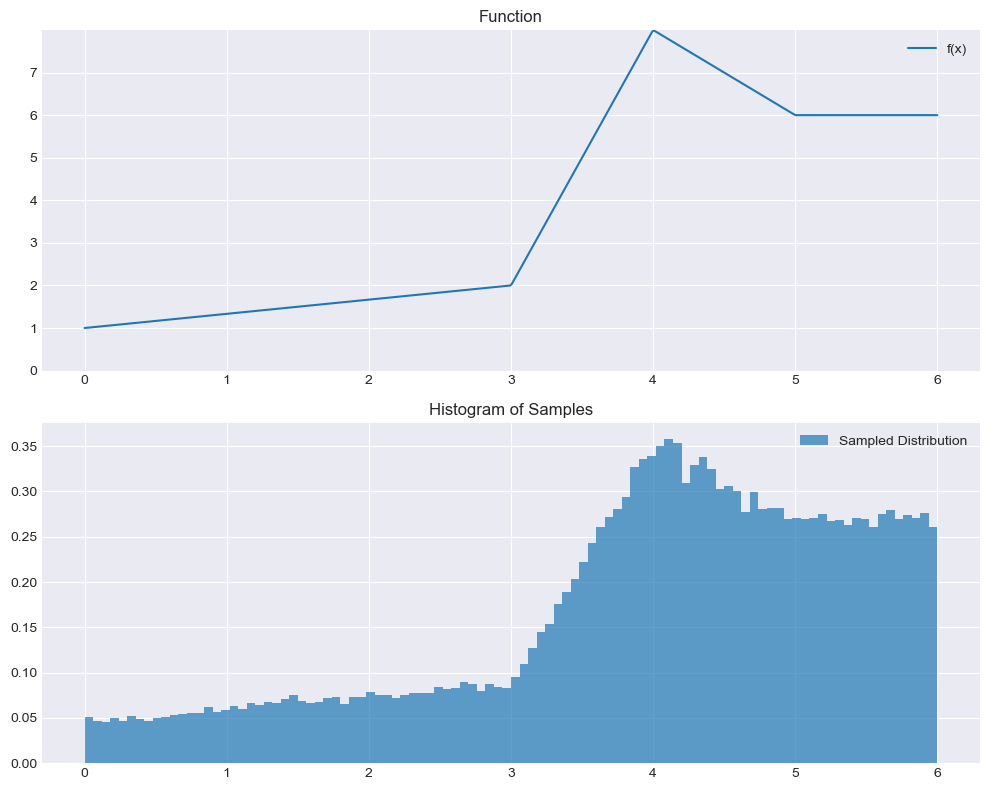

In [6]:
sampler = piecewise_linear_sampler(
    [
        (0, 1),
        (3, 2),
        (4, 8),
        (5, 6),
        (6, 6),
    ]
)
visualize_sampler(sampler, fname="piecewise_linear.png")

In [7]:
def sample_point(sampler) -> tuple[float, float]:
    x = sampler.draw()
    y = random.uniform(0, sampler.f(x))

    return x, y


def visualize_rejection_sampling(
    pdf,
    envelope,
    domain,
    n_frames,
    filename,
):
    x = np.linspace(*domain, 400)
    pdf_y = pdf(x)

    points = []
    accepted_count = 0
    rejected_count = 0

    frame_filenames = []
    for frame in tqdm(range(n_frames), desc="Generating frames"):
        fig, (ax1, ax2) = plt.subplots(
            1, 2, figsize=(10, 4), gridspec_kw={"width_ratios": [3, 1]}
        )

        # Main plot
        ax1.plot(x, pdf_y, label="PDF", color="blue")
        ax1.fill_between(x, pdf_y, alpha=0.2, color="blue")
        ax1.plot(x, [envelope.f(x_) for x_ in x], label="Envelope", color="orange")

        new_x, new_y = sample_point(envelope)
        points.append((new_x, new_y, new_y < pdf(new_x)))

        # Update counters
        accepted_count += new_y < pdf(new_x)
        rejected_count += new_y >= pdf(new_x)

        # Scatter plot
        for px, py, accepted in points:
            color = "green" if accepted else "red"
            ax1.scatter(px, py, color=color, marker="x")

        # Bar plot for counts
        ax2.bar(
            ["Accepted", "Rejected"],
            [accepted_count, rejected_count],
            color=["green", "red"],
        )
        ax2.set_title("Points Count")
        ax2.set_ylim(0, n_frames)

        frame_filename = f"frame_{frame}.png"
        plt.savefig(frame_filename, dpi=150)
        frame_filenames.append(frame_filename)
        plt.close()

    with imageio.get_writer(f"{plots_path}/{filename}", mode="I", fps=20, loop=0) as writer:
        for frame_filename in tqdm(frame_filenames, desc="Compiling GIF"):
            image = imageio.imread(frame_filename)
            writer.append_data(image)

    for frame_filename in frame_filenames:
        os.remove(frame_filename)

In [8]:
normal = Normal(0, 1)
domain = (-10, 10)
visualize_rejection_sampling(
    pdf=normal.pdf,
    envelope=naive_envelope(domain, ymax=1),
    domain=domain,
    n_frames=100,
    filename="rejection_sampling_naive.gif",
)

Compiling GIF:   0%|                                                                                                                | 0/100 [00:00<?, ?it/s]/var/folders/pg/yftfgy0j309dq_sv_0j5q_l80000gp/T/ipykernel_9627/1264452220.py:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_filename)
Compiling GIF: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.62it/s]


In [9]:
domain = (-10, 10)
visualize_rejection_sampling(
    pdf=normal.pdf,
    envelope=naive_envelope(domain, ymax=normal.pdf(0)),
    domain=domain,
    n_frames=100,
    filename="rejection_sampling_low_ceiling.gif",
)

Compiling GIF:   0%|                                                                                                                | 0/100 [00:00<?, ?it/s]/var/folders/pg/yftfgy0j309dq_sv_0j5q_l80000gp/T/ipykernel_9627/1264452220.py:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_filename)
Compiling GIF: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.91it/s]


In [10]:
def visualize_envelope(f, envelope, domain, filename=None):
    xmin, xmax = domain
    x_values = np.linspace(xmin, xmax, 1000)  # Generate values for plotting

    # Evaluate the target and envelope functions at the x values
    y_values_f = [f(x) for x in x_values]
    y_values_envelope = [envelope.f(x) for x in x_values]

    # Create a plot
    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values_f, label="Target Function (f)")
    plt.plot(x_values, y_values_envelope, label="Envelope Function")

    # Set labels and legend
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

    # Set title and show the plot
    plt.title("Target Function and Envelope Function")
    plt.grid(True)

    if filename:
        plt.savefig(f"{plots_path}/{filename}")

    plt.show()

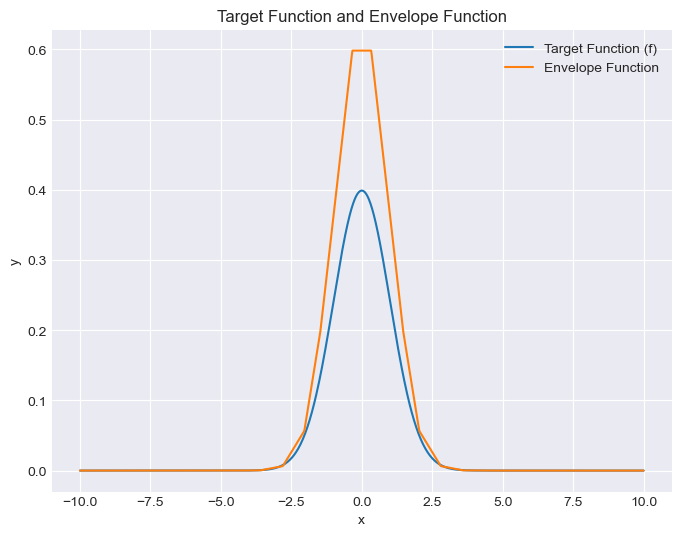

In [11]:
normal = Normal(0, 1)

envelope = piecewise_linear_envelope(
    f=normal.pdf,
    domain=(-10, 10),
    n=25,
    buffer=0.5,
)

visualize_envelope(
    f=normal.pdf,
    envelope=envelope,
    domain=(-10, 10),
    filename="gaussian_envelope.png",
)

In [12]:
domain = (-10, 10)
visualize_rejection_sampling(
    pdf=Normal(0, 1).pdf,
    envelope=envelope,
    domain=domain,
    n_frames=100,
    filename="rejection_sampling_smart_envelope.gif",
)

Compiling GIF:   0%|                                                                                                                | 0/100 [00:00<?, ?it/s]/var/folders/pg/yftfgy0j309dq_sv_0j5q_l80000gp/T/ipykernel_9627/1264452220.py:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_filename)
Compiling GIF: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.33it/s]
